# 07. Final Results - Cross-Method Consensus Analysis

Compare and combine results from **3 independent detection methods** at aggregated portrait level:
1. **Isolation Forest** — global anomalies in information portraits
2. **LOF** (Local Outlier Factor) — local/contextual anomalies in portraits
3. **Network Analysis** — structural anomalies in buyer-supplier graph

**Three analysis levels (3 methods each):**
- **Buyers** (~36K) — IForest vs LOF vs Network (monopolistic buyers)
- **Suppliers** (~360K) — IForest vs LOF vs Network (suspicious bidders)
- **Pairs** (~916K) — IForest vs LOF vs Network (monopolistic pairs)

In [1]:
import sys
sys.path.insert(0, '..')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
from datetime import datetime

from src.data_loader import load_tenders, load_buyers, load_suppliers
from src.detectors import AggregatedPyOD

pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Started: 2026-02-10 23:31:54


## 1. Load Data

In [2]:
tenders = load_tenders(years=[2022, 2023, 2024, 2025])
buyers = load_buyers()
suppliers = load_suppliers()

print(f"Tenders: {len(tenders):,}")
print(f"Buyers: {len(buyers):,}")
print(f"Suppliers: {len(suppliers):,}")

Scanning 2022...
Scanning 2023...
Scanning 2024...
Scanning 2025...
Loaded 12,877,960 records
Loaded buyers: 35,995
Loaded suppliers: 358,376
Tenders: 12,877,960
Buyers: 35,995
Suppliers: 358,376


## 2. Aggregated ML Analysis (IForest + LOF)

Run both algorithms **independently** at all 3 portrait levels.
Each algorithm produces its own set of flagged entities.

In [3]:
flagged = {
    'IForest': {'buyers': set(), 'suppliers': set(), 'pairs': set()},
    'LOF': {'buyers': set(), 'suppliers': set(), 'pairs': set()},
}

for algo_name, algo_key in [('IForest', 'iforest'), ('LOF', 'lof')]:
    print(f"\n{'='*60}")
    print(f"{algo_name}")
    print(f"{'='*60}")
    
    detector = AggregatedPyOD(algorithm=algo_key, contamination=0.05)
    
    # Buyers
    start = datetime.now()
    buyer_res = detector.detect_buyers(tenders)
    buyer_anom = buyer_res[buyer_res['anomaly'] == 1]
    flagged[algo_name]['buyers'] = set(buyer_anom['buyer_id'])
    elapsed = (datetime.now() - start).total_seconds()
    print(f"  Buyers: {len(buyer_anom):,} anomalies ({elapsed:.1f}s)")
    
    if algo_key == 'iforest':
        fi = detector.feature_importances('buyers')
        if fi:
            print("  Feature importance (top 5):")
            for feat, imp in list(fi.items())[:5]:
                print(f"    {feat}: {imp:.4f}")
    
    # Suppliers
    start = datetime.now()
    supplier_res = detector.detect_suppliers(tenders)
    supplier_anom = supplier_res[supplier_res['anomaly'] == 1]
    flagged[algo_name]['suppliers'] = set(supplier_anom['supplier_id'])
    elapsed = (datetime.now() - start).total_seconds()
    print(f"  Suppliers: {len(supplier_anom):,} anomalies ({elapsed:.1f}s)")
    
    # Pairs
    start = datetime.now()
    pair_res = detector.detect_pairs(tenders, min_contracts=3)
    pair_anom = pair_res[pair_res['anomaly'] == 1]
    flagged[algo_name]['pairs'] = set(zip(pair_anom['buyer_id'], pair_anom['supplier_id']))
    elapsed = (datetime.now() - start).total_seconds()
    print(f"  Pairs: {len(pair_anom):,} anomalies ({elapsed:.1f}s)")


IForest
AggregatedPyOD (IFOREST): Detecting anomalous BUYERS...
  Computing buyer features from tenders...
  Features: ['single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_tenders', 'avg_value', 'total_value', 'cpv_concentration', 'avg_award_days', 'weekend_rate', 'value_variance_coeff', 'q4_rate']
  Buyers: 35,995
  Anomalies: 1,800 (5.0%)
  Buyers: 1,800 anomalies (7.2s)
  Feature importance (top 5):
    total_value: 0.1225
    avg_value: 0.1098
    total_tenders: 0.0982
    q4_rate: 0.0979
    value_variance_coeff: 0.0923
AggregatedPyOD (IFOREST): Detecting anomalous SUPPLIERS...
  Computing supplier features from tenders...
  Features: ['total_awards', 'total_value', 'avg_award_value', 'buyer_count', 'single_bidder_rate', 'avg_competitors', 'cpv_diversity']
  Suppliers: 358,377
  Anomalies: 17,919 (5.0%)
  Suppliers: 17,919 anomalies (10.5s)
AggregatedPyOD (IFOREST): Detecting anomalous PAIRS...
  Computing pair features from tenders...

## 3. Network Analysis Results

In [4]:
network_suspicious = pd.read_csv('../results/network_suspicious_bidders.csv')
network_rotation = pd.read_csv('../results/network_bid_rotation.csv')
network_monopolistic = pd.read_csv('../results/network_monopolistic.csv')

network_buyer_set = set(network_monopolistic['buyer_id'])
network_supplier_set = set(network_suspicious['bidder_id'])
network_pair_set = set(zip(network_monopolistic['buyer_id'], network_monopolistic['supplier_id']))

print("Network Analysis Results:")
print(f"  Monopolistic buyers: {len(network_buyer_set):,}")
print(f"  Suspicious bidders: {len(network_supplier_set):,}")
print(f"  Bid rotation pairs: {len(network_rotation):,}")
print(f"  Monopolistic pairs: {len(network_pair_set):,}")

Network Analysis Results:
  Monopolistic buyers: 5,266
  Suspicious bidders: 5,394
  Bid rotation pairs: 18,126
  Monopolistic pairs: 5,266


## 4. Cross-Method Consensus Analysis

In [5]:
# Buyers: 3 methods (IForest, LOF, Network monopolistic buyers)
buyer_methods = {
    'IForest': flagged['IForest']['buyers'],
    'LOF': flagged['LOF']['buyers'],
    'Network': network_buyer_set,
}

# Suppliers: 3 methods
supplier_methods = {
    'IForest': flagged['IForest']['suppliers'],
    'LOF': flagged['LOF']['suppliers'],
    'Network': network_supplier_set,
}

# Pairs: 3 methods
pair_methods = {
    'IForest': flagged['IForest']['pairs'],
    'LOF': flagged['LOF']['pairs'],
    'Network': network_pair_set,
}

def consensus_analysis(methods, level_name):
    """Count how many methods flagged each entity."""
    print(f"\n{'='*60}")
    print(f"{level_name}")
    print(f"{'='*60}")
    
    for name, ids in methods.items():
        print(f"  {name}: {len(ids):,}")
    
    all_flagged = []
    for ids in methods.values():
        all_flagged.extend(ids)
    flag_counts = Counter(all_flagged)
    
    print(f"\nConsensus:")
    for t in range(1, len(methods) + 1):
        count = len([x for x, c in flag_counts.items() if c >= t])
        print(f"  >= {t} methods: {count:,}")
    
    return flag_counts

buyer_counts = consensus_analysis(buyer_methods, "BUYER-LEVEL (3 methods: IForest, LOF, Network)")
supplier_counts = consensus_analysis(supplier_methods, "SUPPLIER-LEVEL (3 methods: IForest, LOF, Network)")
pair_counts = consensus_analysis(pair_methods, "PAIR-LEVEL (3 methods: IForest, LOF, Network)")


BUYER-LEVEL (3 methods: IForest, LOF, Network)
  IForest: 1,800
  LOF: 1,800
  Network: 5,266

Consensus:
  >= 1 methods: 7,293
  >= 2 methods: 1,394
  >= 3 methods: 179

SUPPLIER-LEVEL (3 methods: IForest, LOF, Network)
  IForest: 17,919
  LOF: 17,919
  Network: 5,394

Consensus:
  >= 1 methods: 38,274
  >= 2 methods: 2,946
  >= 3 methods: 12

PAIR-LEVEL (3 methods: IForest, LOF, Network)
  IForest: 45,814
  LOF: 45,814
  Network: 5,266

Consensus:
  >= 1 methods: 85,345
  >= 2 methods: 11,058
  >= 3 methods: 491


## 5. Jaccard Similarity Between Methods

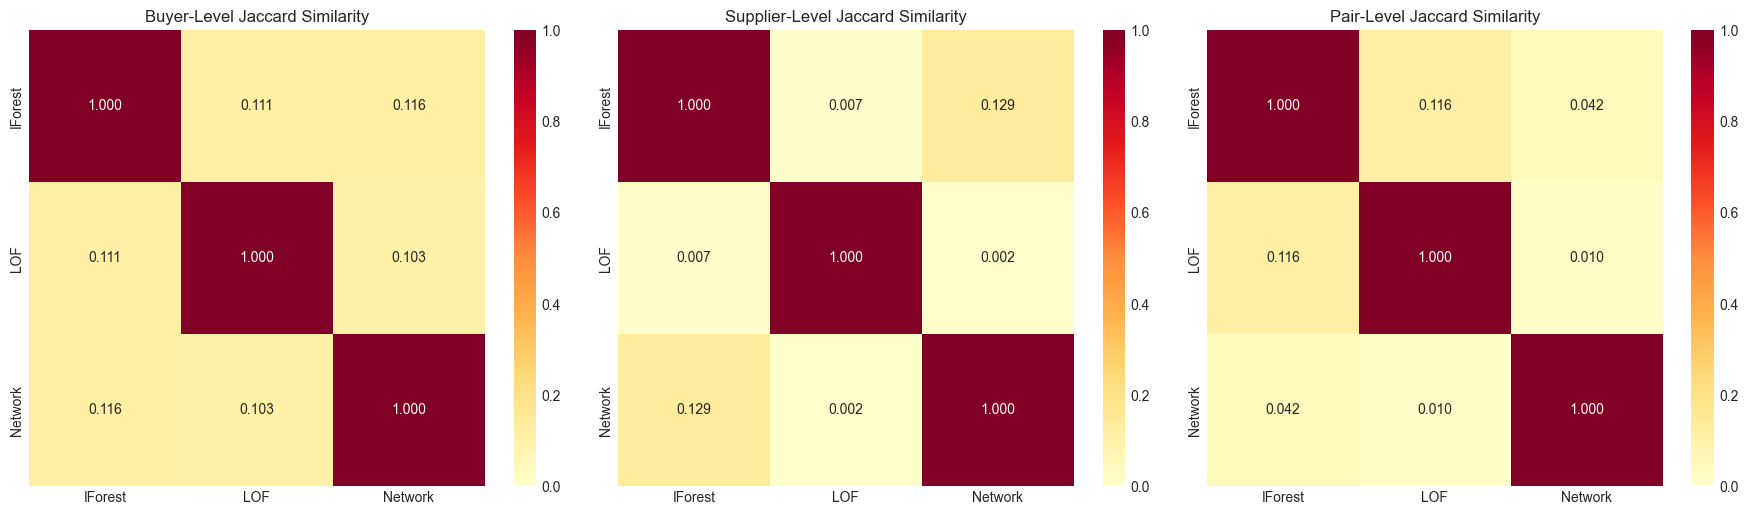

Pairwise Jaccard Index:

Buyer-Level:
  IForest vs LOF: J=0.111 (360 common)
  IForest vs Network: J=0.116 (734 common)
  LOF vs Network: J=0.103 (658 common)

Supplier-Level:
  IForest vs LOF: J=0.007 (260 common)
  IForest vs Network: J=0.129 (2,663 common)
  LOF vs Network: J=0.002 (47 common)

Pair-Level:
  IForest vs LOF: J=0.116 (9,496 common)
  IForest vs Network: J=0.042 (2,051 common)
  LOF vs Network: J=0.010 (493 common)


In [6]:
def jaccard_index(set1, set2):
    if len(set1) == 0 and len(set2) == 0:
        return 0.0
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0

os.makedirs('../results/figures', exist_ok=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (level_name, methods) in zip(axes, [
    ('Buyer', buyer_methods),
    ('Supplier', supplier_methods),
    ('Pair', pair_methods),
]):
    names = list(methods.keys())
    matrix = pd.DataFrame(index=names, columns=names, dtype=float)
    
    for m1, m2 in combinations(names, 2):
        j = jaccard_index(methods[m1], methods[m2])
        matrix.loc[m1, m2] = j
        matrix.loc[m2, m1] = j
    for m in names:
        matrix.loc[m, m] = 1.0
    
    sns.heatmap(matrix.astype(float), annot=True, fmt='.3f',
                cmap='YlOrRd', square=True, ax=ax, vmin=0, vmax=1)
    ax.set_title(f'{level_name}-Level Jaccard Similarity')

plt.tight_layout()
plt.savefig('../results/figures/cross_method_jaccard.png', dpi=150, bbox_inches='tight')
plt.show()

# Print pairwise
print("Pairwise Jaccard Index:")
for level_name, methods in [('Buyer', buyer_methods), ('Supplier', supplier_methods), ('Pair', pair_methods)]:
    print(f"\n{level_name}-Level:")
    for m1, m2 in combinations(methods.keys(), 2):
        j = jaccard_index(methods[m1], methods[m2])
        common = len(methods[m1] & methods[m2])
        print(f"  {m1} vs {m2}: J={j:.3f} ({common:,} common)")

## 6. Top Anomalies for Case Studies

In [7]:
# Top anomalous buyers (2+ methods agree)
high_consensus_buyers_2 = [b for b, c in buyer_counts.items() if c >= 2]
high_consensus_buyers_3 = [b for b, c in buyer_counts.items() if c >= 3]

print(f"Buyers flagged by >= 2 methods: {len(high_consensus_buyers_2):,}")
print(f"Buyers flagged by all 3 methods: {len(high_consensus_buyers_3):,}")

if high_consensus_buyers_2:
    top_buyers_df = buyers[buyers['buyer_id'].isin(high_consensus_buyers_2)].copy()
    top_buyers_df['methods_flagged'] = top_buyers_df['buyer_id'].map(buyer_counts)
    top_buyers_df = top_buyers_df.sort_values(['methods_flagged', 'total_value'], ascending=[False, False])
    
    print(f"Total value: {top_buyers_df['total_value'].sum()/1e9:.2f} B UAH")
    print(f"Mean single_bidder_rate: {top_buyers_df['single_bidder_rate'].mean()*100:.1f}%")
    
    print("\nTop 10 by priority:")
    display(top_buyers_df.head(10)[['buyer_id', 'buyer_name', 'methods_flagged',
                                     'total_tenders', 'total_value', 'single_bidder_rate']])
    
    top_buyers_df.to_csv('../results/case_study_buyers.csv', index=False)
    print(f"Saved {len(top_buyers_df)} buyers to case_study_buyers.csv")
else:
    print("No high-consensus buyers found")

Buyers flagged by >= 2 methods: 1,394
Buyers flagged by all 3 methods: 179
Total value: 585.49 B UAH
Mean single_bidder_rate: 9.4%

Top 10 by priority:


,buyer_id,buyer_name,methods_flagged,total_tenders,total_value,single_bidder_rate
2184,26641920,Військова частина Т0160,3,1360,6.592400e+09,0.002206
2571,33148732,ВІЙСЬКОВА ЧАСТИНА Т0710,3,1242,4.841531e+09,0.422222
16341,04014045,Департамент капітального будівництва Сумської ...,3,152,3.223374e+09,0.000000
9518,14323511,Центральна база забезпечення пально-мастильним...,3,373,2.969330e+09,0.120482
7385,43380399,"Департамент розвитку громад та територій, дор...",3,507,1.816853e+09,0.050847
12243,14323534,військова частина 2276 Національної гвардії Ук...,3,265,1.083466e+09,0.419355
3585,20001438,Військова частина Е6117,3,979,4.659308e+08,0.233533
31714,02671419,Київська міська організація Профспілки працівн...,3,5,6.481540e+07,0.000000
33601,40219073,ОБ′ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...,3,2,4.529772e+07,0.000000
34610,45522091,БЛАГОДІЙНА ОРГАНІЗАЦІЯ «БЛАГОДІЙНИЙ ФОНД „ЯНГО...,3,1,4.300000e+07,0.000000


Saved 1394 buyers to case_study_buyers.csv


In [8]:
# Top anomalous suppliers (2+ methods agree)
high_consensus_suppliers_2 = [s for s, c in supplier_counts.items() if c >= 2]
high_consensus_suppliers_3 = [s for s, c in supplier_counts.items() if c >= 3]

print(f"Suppliers flagged by >= 2 methods: {len(high_consensus_suppliers_2):,}")
print(f"Suppliers flagged by all 3 methods: {len(high_consensus_suppliers_3):,}")

if high_consensus_suppliers_2:
    top_suppliers_df = suppliers[suppliers['supplier_id'].isin(high_consensus_suppliers_2)].copy()
    top_suppliers_df['methods_flagged'] = top_suppliers_df['supplier_id'].map(supplier_counts)
    top_suppliers_df = top_suppliers_df.sort_values(['methods_flagged', 'total_value'], ascending=[False, False])
    
    print(f"\nTop 20 by priority:")
    display(top_suppliers_df.head(20)[['supplier_id', 'supplier_name', 'methods_flagged',
                                       'total_awards', 'total_value']])
    
    top_suppliers_df.to_csv('../results/case_study_suppliers.csv', index=False)
    print(f"Saved {len(top_suppliers_df)} suppliers to case_study_suppliers.csv")

Suppliers flagged by >= 2 methods: 2,946
Suppliers flagged by all 3 methods: 12

Top 20 by priority:


,supplier_id,supplier_name,methods_flagged,total_awards,total_value
17851,32984271,"АКЦІОНЕРНЕ ТОВАРИСТВО ""ЕНЕРГЕТИЧНА КОМПАНІЯ УК...",3,139,1.546280e+10
247,45179093,"ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ""ЯСНО+""",3,2737,6.236281e+09
180492,00376403,"ТОВ ""БУСЬКИЙ КОНСЕРВНИЙ ЗАВОД""",3,3,4.334063e+09
227742,40938984,"ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ""ФАРМІ...",3,2,5.499130e+07
434,3193411786,"ФОП ""МОРГОНЮК АЛІНА АНАТОЛІЇВНА""",3,2013,3.290927e+07
105,3466208476,Рудзінський Ігор Анатолійович,3,4273,1.857876e+07
47231,2793005856,"ФОП ""СТАРЕНЬКИЙ ІВАН АНАТОЛІЙОВИЧ""",3,44,7.732259e+06
191499,44788710,ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ «Науко...,3,3,4.851139e+06
54678,3699105683,ФОП МАГАС ТЕТЯНА ВОЛОДИМИРІВНА,3,35,4.780240e+06
71539,42137312,ТОВ БІЛТЕК ГРУП,3,23,1.439493e+06


Saved 2946 suppliers to case_study_suppliers.csv


In [9]:
# Top anomalous pairs (2+ methods agree)
high_consensus_pairs_2 = [(b, s) for (b, s), c in pair_counts.items() if c >= 2]
high_consensus_pairs_3 = [(b, s) for (b, s), c in pair_counts.items() if c >= 3]

print(f"Pairs flagged by >= 2 methods: {len(high_consensus_pairs_2):,}")
print(f"Pairs flagged by all 3 methods: {len(high_consensus_pairs_3):,}")

if high_consensus_pairs_2:
    pairs_list = [(b, s, pair_counts[(b, s)]) for b, s in high_consensus_pairs_2]
    top_pairs_df = pd.DataFrame(pairs_list, columns=['buyer_id', 'supplier_id', 'methods_flagged'])
    
    top_pairs_df = top_pairs_df.merge(
        buyers[['buyer_id', 'buyer_name']], on='buyer_id', how='left'
    ).merge(
        suppliers[['supplier_id', 'supplier_name']], on='supplier_id', how='left'
    )
    
    top_pairs_df = top_pairs_df.sort_values(['methods_flagged', 'buyer_id'], ascending=[False, True])
    
    print(f"\nTop 20:")
    display(top_pairs_df.head(20))
    
    top_pairs_df.to_csv('../results/case_study_pairs.csv', index=False)
    print(f"Saved {len(top_pairs_df)} pairs to case_study_pairs.csv")

Pairs flagged by >= 2 methods: 11,058
Pairs flagged by all 3 methods: 491

Top 20:


,buyer_id,supplier_id,methods_flagged,buyer_name,supplier_name
5049,00152603,2284911319,3,"ДЕРЖАВНЕ ПІДПРИЄМСТВО ""ВОЛОДИМИРІВСЬКЕ ЛІСОВЕ ...",ФОП Козаченко Ю.А.
5593,00194122,32072689,3,"АКЦІОНЕРНЕ ТОВАРИСТВО ""ЗАПОРІЗЬКИЙ ВИРОБНИЧИЙ ...","Приватне підприємство ""Зорі України"""
1576,00426302,00991545,3,"Державне підприємство ""Волиньторф""","ДЕРЖАВНЕ ПІДПРИЄМСТВО ""МАНЕВИЦЬКЕ ЛІСОВЕ ГОСПО..."
7104,00689190,42129720,3,"ДП ""Івано-Франківський інститут землеустрою""","ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ""ПРИКА..."
6178,00702995,2388914055,3,"ДП ""Одеський науково-дослідний та проектний ін...","ФОП ""ПАШИНОВ ОЛЕКСАНДР СТЕПАНОВИЧ"""
2856,00705798,3045015151,3,Валківська районна державна лікарня ветеринарн...,Фізична особа-підприємець Зягун Микола Володим...
10863,00711793,2943022214,3,Полонська районна державна лікарня ветеринарно...,ФОП Малогловець Юрій Анатолійович
5325,00730307,3092507032,3,Відділ з питань ветеранської політики Володими...,БІЛАН ПАВЛО ВАСИЛЬОВИЧ
5486,00914527,44173043,3,ДЕРЖАВНИЙ ПРОФЕСІЙНО-ТЕХНІЧНИЙ НАВЧАЛЬНИЙ ЗАКЛ...,ТОВ НЦ Професійна освіта
1904,00991634,40726032,3,"Державне підприємство ""Новомосковське лісове г...","ТОВ ""ВУД КОМПАНІ УКРАЇНА"""


Saved 11058 pairs to case_study_pairs.csv


## 7. Summary for Thesis

In [10]:
print("="*70)
print("CROSS-METHOD CONSENSUS SUMMARY")
print("="*70)

n_buyer_2 = len([b for b, c in buyer_counts.items() if c >= 2])
n_buyer_3 = len([b for b, c in buyer_counts.items() if c >= 3])
n_supplier_2 = len([s for s, c in supplier_counts.items() if c >= 2])
n_supplier_3 = len([s for s, c in supplier_counts.items() if c >= 3])
n_pair_2 = len([p for p, c in pair_counts.items() if c >= 2])
n_pair_3 = len([p for p, c in pair_counts.items() if c >= 3])

print(f"\nBuyer-Level (IForest vs LOF vs Network):")
print(f"  IForest: {len(flagged['IForest']['buyers']):,}")
print(f"  LOF: {len(flagged['LOF']['buyers']):,}")
print(f"  Network: {len(network_buyer_set):,}")
print(f"  >= 2 methods: {n_buyer_2:,}")
print(f"  All 3 methods: {n_buyer_3:,}")

print(f"\nSupplier-Level (IForest vs LOF vs Network):")
print(f"  IForest: {len(flagged['IForest']['suppliers']):,}")
print(f"  LOF: {len(flagged['LOF']['suppliers']):,}")
print(f"  Network: {len(network_supplier_set):,}")
print(f"  >= 2 methods: {n_supplier_2:,}")
print(f"  All 3 methods: {n_supplier_3:,}")

print(f"\nPair-Level (IForest vs LOF vs Network):")
print(f"  IForest: {len(flagged['IForest']['pairs']):,}")
print(f"  LOF: {len(flagged['LOF']['pairs']):,}")
print(f"  Network: {len(network_pair_set):,}")
print(f"  >= 2 methods: {n_pair_2:,}")
print(f"  All 3 methods: {n_pair_3:,}")

# Save summary
summary_data = {
    'Level': ['Buyers', 'Buyers', 'Buyers', 'Buyers', 'Buyers',
              'Suppliers', 'Suppliers', 'Suppliers', 'Suppliers', 'Suppliers',
              'Pairs', 'Pairs', 'Pairs', 'Pairs', 'Pairs'],
    'Metric': [
        'IForest anomalies', 'LOF anomalies', 'Network monopolistic',
        '>= 2 methods', 'All 3 methods',
        'IForest anomalies', 'LOF anomalies', 'Network suspicious',
        '>= 2 methods', 'All 3 methods',
        'IForest anomalies', 'LOF anomalies', 'Network monopolistic',
        '>= 2 methods', 'All 3 methods',
    ],
    'Count': [
        len(flagged['IForest']['buyers']), len(flagged['LOF']['buyers']),
        len(network_buyer_set), n_buyer_2, n_buyer_3,
        len(flagged['IForest']['suppliers']), len(flagged['LOF']['suppliers']),
        len(network_supplier_set), n_supplier_2, n_supplier_3,
        len(flagged['IForest']['pairs']), len(flagged['LOF']['pairs']),
        len(network_pair_set), n_pair_2, n_pair_3,
    ],
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('../results/thesis_summary_statistics.csv', index=False)
display(summary_df)
print("\nSaved to thesis_summary_statistics.csv")

CROSS-METHOD CONSENSUS SUMMARY

Buyer-Level (IForest vs LOF vs Network):
  IForest: 1,800
  LOF: 1,800
  Network: 5,266
  >= 2 methods: 1,394
  All 3 methods: 179

Supplier-Level (IForest vs LOF vs Network):
  IForest: 17,919
  LOF: 17,919
  Network: 5,394
  >= 2 methods: 2,946
  All 3 methods: 12

Pair-Level (IForest vs LOF vs Network):
  IForest: 45,814
  LOF: 45,814
  Network: 5,266
  >= 2 methods: 11,058
  All 3 methods: 491


,Level,Metric,Count
0,Buyers,IForest anomalies,1800
1,Buyers,LOF anomalies,1800
2,Buyers,Network monopolistic,5266
3,Buyers,>= 2 methods,1394
4,Buyers,All 3 methods,179
5,Suppliers,IForest anomalies,17919
6,Suppliers,LOF anomalies,17919
7,Suppliers,Network suspicious,5394
8,Suppliers,>= 2 methods,2946
9,Suppliers,All 3 methods,12



Saved to thesis_summary_statistics.csv


In [11]:
print(f"Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Completed: 2026-02-10 23:33:40
